In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from skimage.draw import ellipse
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage import measure
from DataManager import DataManager
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from utils import reshape_insole_grid,segment_insole_data,calculate_peak_impulse,calculate_region_impulse,calculate_relative_region_impulse, plot_insole_grid, anova_test

# Andrew

In [3]:
with open('data/080624_seg_coords.pkl', 'rb') as file:
    coords = pickle.load(file)
cord_df = pd.DataFrame(coords)

In [7]:
trials = ['','2','3','4']
speeds = ['0.6','1.0','1.4','1.8']
split_data_cols = ['080624_walkstrike_r','080624_walk2strike_r','080624_walk3strike_r','080624_walk4strike_r']
resample_frames = 500
final_df = pd.DataFrame()

for i, speed in enumerate(speeds):
    data_file_name = f'GAIT080624-01/gait_recording_080624_walk{trials[i]}.mat'
    data = sio.loadmat('data/'+data_file_name)

    # # Right Foot
    # insoleAll_r = data['insoleAll_r'].astype(np.float64)
    # insole_r = insoleAll_r.reshape((-1, 64, 16), order="F")
    # # need to flip the top half of the heatmap up-down
    # insole_r[:, :32, :] = np.flip(insole_r[:, :32, :], axis=1)
    # # insole_spatial_r = np.flip(insole_r, axis=2)
    # t_insole_r = data['t_insole_r'].astype(np.float64)

    # height_seg_cords_r = cord_df[cord_df['filename'] == data_file_name.split('/')[1]].reset_index(drop = True)['height_valleys_r'][0]
    # width_seg_cords_r = [[16-x] for x in cord_df[cord_df['filename'] == data_file_name.split('/')[1]].reset_index(drop = True)['width_valleys_r'][0]] + [[]]


    # Left Foot
    insoleAll_l = data['insoleAll_l'].astype(np.float64)
    insole_l = insoleAll_l.reshape((-1, 64, 16), order="F")
    # need to flip the top half of the heatmap up-down
    insole_l[:, :32, :] = np.flip(insole_l[:, :32, :], axis=1)
    t_insole_l = data['t_insole_l'].astype(np.float64)
    height_seg_cords_r = cord_df[cord_df['filename'] == data_file_name.split('/')[1]].reset_index(drop = True)['height_valleys_l'][0]
    width_seg_cords_r = [[x] for x in cord_df[cord_df['filename'] == data_file_name.split('/')[1]].reset_index(drop = True)['width_valleys_l'][0]] + [[]]


    insole_data = insoleAll_l


    # Resampling Frames based on Walking Cycle
    split_idx_df = pd.read_csv('data/strikeandoffindices.csv')
    cycle_idx = split_idx_df[split_data_cols[i]].dropna()
    cycle_number = 10
    start_idx = [cycle_idx[i] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]
    end_idx = [cycle_idx[i+cycle_number] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]

    for j,_ in tqdm(enumerate(start_idx)):
        
        input_insole = insole_data[int(start_idx[j]):int(end_idx[j])]
        if input_insole.shape[0] == 0:
            continue
        segmented_dict = segment_insole_data(input_insole, height_seg_cords_r, width_seg_cords_r)
        output_df = calculate_relative_region_impulse(segmented_dict)
        output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(segmented_dict[x]))
        output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
        output_df['sample_idx'] = j
        output_df['foot'] = 'right'
        output_df['speed'] = speed
        final_df = pd.concat([final_df, output_df], axis = 0, ignore_index=True)


final_df['region index'] = final_df['Region'].apply(lambda x : x.split('|')[1])
final_df['Region'] = final_df['Region'].apply(lambda x : x.split('|')[0])
final_df.to_excel('data/speed_comparison_table.xlsx',index = False)

11it [00:00, 72.00it/s]
12it [00:00, 65.52it/s]
15it [00:00, 83.68it/s]
14it [00:00, 80.31it/s]


In [8]:
final_df

,Region,Peak Pressure,Regional Impulse,Relative Regional Impulse,sample_idx,foot,speed,region index
0,"(0-12,0-7)",745.130667,2220.297600,0.251614,0,right,0.6,1
1,"(0-12,7-16)",731.918478,1685.005326,0.190952,0,right,0.6,2
2,"(12-31,0-10)",356.327771,1111.565488,0.125967,0,right,0.6,3
3,"(12-31,10-16)",556.754430,1467.758418,0.166333,0,right,0.6,4
4,"(31-64,0-16)",682.700315,2339.600505,0.265134,0,right,0.6,5
...,...,...,...,...,...,...,...,...
255,"(0-10,0-7)",507.610000,1438.610000,0.176764,13,right,1.8,1
256,"(0-10,7-16)",496.607843,1096.194510,0.134691,13,right,1.8,2
257,"(10-31,0-11)",494.009888,1606.617636,0.197408,13,right,1.8,3
258,"(10-31,11-16)",582.816867,1671.381566,0.205365,13,right,1.8,4


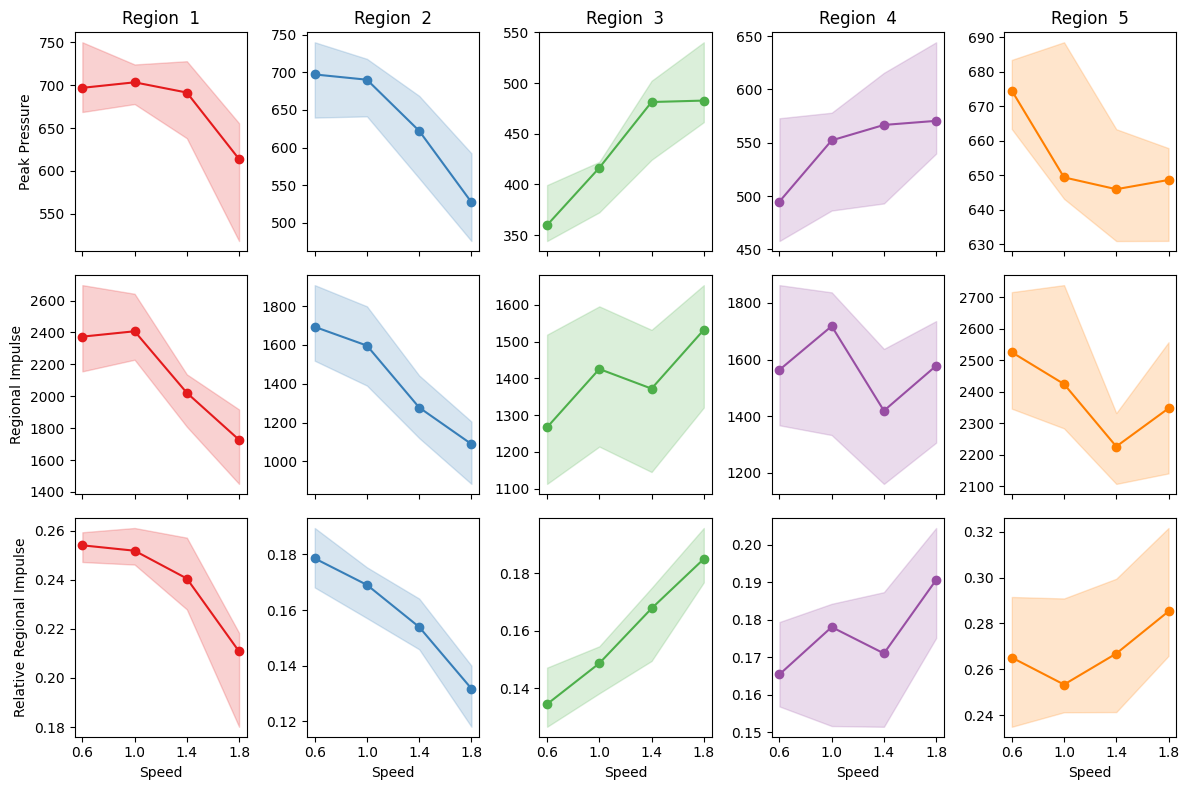

In [9]:
df = final_df

# Define the variables for plotting
metrics = ['Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']
region_indices = df['region index'].unique()
palette = dict(zip(range(5), sns.color_palette("Set1", len(region_indices))))
speeds = sorted(df['speed'].unique())

# Set up the figure and subplots with exchanged dimensions (3 rows, 5 columns)
fig, axes = plt.subplots(len(metrics), len(region_indices), figsize=(12, 8), sharex=True, sharey=False)

# Iterate over metrics and region indices to plot the data
for i, metric in enumerate(metrics):
    for j, region in enumerate(region_indices):
        ax = axes[i, j]

        # Filter data for the given region
        region_data = df[df['region index'] == region]

        # Compute median and 95% range for each speed
        medians = []
        lower_95 = []
        upper_95 = []

        for speed in speeds:
            speed_data = region_data[region_data['speed'] == speed][metric]
            medians.append(speed_data.median())
            lower_95.append(np.percentile(speed_data, 2.5))
            upper_95.append(np.percentile(speed_data, 97.5))

        # Plot the median with shaded 95% range
        ax.plot(speeds, medians, marker='o', linestyle='-', label=f'Region {region}', color = palette[j])
        ax.fill_between(speeds, lower_95, upper_95, alpha=0.2,color = palette[j])

        # Labels and titles
        if j == 0:
            ax.set_ylabel(metric)
        if i == 0:
            ax.set_title(f'Region {region}')
        if i == len(metrics) - 1:
            ax.set_xlabel("Speed")

fig.tight_layout()
plt.show()